In [1]:
!python -V

Python 3.12.9


In [4]:
import pandas as pd
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

mlflow.__version__
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("duration-prediction")

2025/05/15 20:00:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/05/15 20:00:56 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/inigo_ocariz/src/ml-zoomcamp/02-experiment-tracking/src/02_experiment_tracking/mlruns/1', creation_time=1747332056866, experiment_id='1', last_update_time=1747332056866, lifecycle_stage='active', name='duration-prediction', tags={}>

In [6]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829626

/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_3904/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_3904/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label

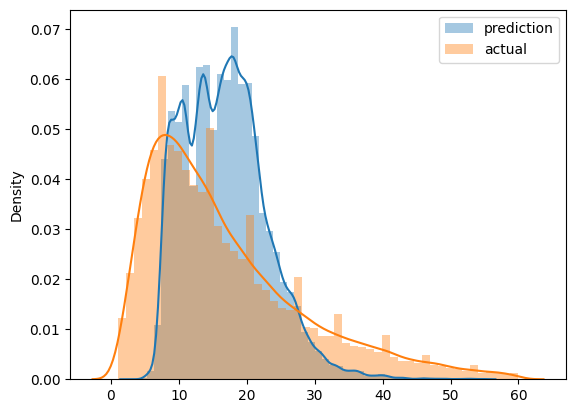

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)


(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_


7.758715204796038

In [27]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [28]:


with mlflow.start_run():

    alpha = 0.001

    mlflow.log_params({
        "train-data-path": "./data/green_tripdata_2021-01.parquet",
        "val-data-path": "./data/green_tripdata_2021-02.parquet",
        "model": "lasso",
        "alpha": alpha
    })

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(lr, artifact_path="models", registered_model_name="lasso")

    print(f"The RMSE of the lasso model is {rmse}")
    

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
2025/05/15 21:30:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/15 21:30:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


The RMSE of the lasso model is 9.233436225720547


Registered model 'lasso' already exists. Creating a new version of this model...
Created version '2' of model 'lasso'.


In [19]:
import xgboost as xgb

In [22]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:11.69533                          
[1]	validation-rmse:11.22125                          
[2]	validation-rmse:10.78743                          
[3]	validation-rmse:10.39142                          
[4]	validation-rmse:10.03065                          
[5]	validation-rmse:9.70267                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:9.40408                           
[7]	validation-rmse:9.13382                           
[8]	validation-rmse:8.88969                           
[9]	validation-rmse:8.66860                           
[10]	validation-rmse:8.46896                          
[11]	validation-rmse:8.28863                          
[12]	validation-rmse:8.12652                          
[13]	validation-rmse:7.97968                          
[14]	validation-rmse:7.84692                          
[15]	validation-rmse:7.72826                          
[16]	validation-rmse:7.62117                          
[17]	validation-rmse:7.52558                          
[18]	validation-rmse:7.43895                          
[19]	validation-rmse:7.36140                          
[20]	validation-rmse:7.29211                          
[21]	validation-rmse:7.23014                          
[22]	validation-rmse:7.17448                          
[23]	validation-rmse:7.12442                          
[24]	valid

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:11:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:10.89401                                                   
[3]	validation-rmse:10.52152                                                   
[4]	validation-rmse:10.17871                                                   
[5]	validation-rmse:9.86372                                                    
[6]	validation-rmse:9.57487                                                    
[7]	validation-rmse:9.31004                                                    
[8]	validation-rmse:9.06787                                                    
[9]	validation-rmse:8.84732                                                    
[10]	validation-rmse:8.64564                                                   
[11]	validation-rmse:8.46186                                                   
[12]	validation-rmse:8.29495                                                   
[13]	validation-rmse:8.14280                                                   
[14]	validation-rmse:8.00448            

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:12:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.73066                                                    
[5]	validation-rmse:6.72246                                                    
[6]	validation-rmse:6.72121                                                    
[7]	validation-rmse:6.71731                                                    
[8]	validation-rmse:6.71345                                                    
[9]	validation-rmse:6.70711                                                    
[10]	validation-rmse:6.70481                                                   
[11]	validation-rmse:6.71259                                                   
[12]	validation-rmse:6.70886                                                   
[13]	validation-rmse:6.71027                                                   
[14]	validation-rmse:6.70645                                                   
[15]	validation-rmse:6.70638                                                   
[16]	validation-rmse:6.70858            

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:12:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:10.16049                                                   
[6]	validation-rmse:9.89527                                                    
[7]	validation-rmse:9.64827                                                    
[8]	validation-rmse:9.41874                                                    
[9]	validation-rmse:9.20612                                                    
[10]	validation-rmse:9.00852                                                   
[11]	validation-rmse:8.82574                                                   
[12]	validation-rmse:8.65643                                                   
[13]	validation-rmse:8.50026                                                   
[14]	validation-rmse:8.35564                                                   
[15]	validation-rmse:8.22241                                                   
[16]	validation-rmse:8.09928                                                   
[17]	validation-rmse:7.98482            

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:13:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.31128                                                    
[2]	validation-rmse:7.54788                                                    
[3]	validation-rmse:7.14306                                                    
[4]	validation-rmse:6.92629                                                    
[5]	validation-rmse:6.80174                                                    
[6]	validation-rmse:6.73473                                                    
[7]	validation-rmse:6.69627                                                    
[8]	validation-rmse:6.67260                                                    
[9]	validation-rmse:6.65357                                                    
[10]	validation-rmse:6.64270                                                   
[11]	validation-rmse:6.63371                                                   
[12]	validation-rmse:6.62943                                                   
[13]	validation-rmse:6.62544            

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:8.12094                                                   
[6]	validation-rmse:7.83143                                                   
[7]	validation-rmse:7.60350                                                   
[8]	validation-rmse:7.42407                                                   
[9]	validation-rmse:7.28264                                                   
[10]	validation-rmse:7.17210                                                  
[11]	validation-rmse:7.08470                                                  
[12]	validation-rmse:7.01622                                                  
[13]	validation-rmse:6.96214                                                  
[14]	validation-rmse:6.91955                                                  
[15]	validation-rmse:6.88510                                                  
[16]	validation-rmse:6.85547                                                  
[17]	validation-rmse:6.83291                        

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:13:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.91483                                                   
[1]	validation-rmse:6.58010                                                   
[2]	validation-rmse:6.53187                                                   
[3]	validation-rmse:6.52732                                                   
[4]	validation-rmse:6.51615                                                   
[5]	validation-rmse:6.50946                                                   
[6]	validation-rmse:6.49946                                                   
[7]	validation-rmse:6.49084                                                   
[8]	validation-rmse:6.48322                                                   
[9]	validation-rmse:6.48154                                                   
[10]	validation-rmse:6.48070                                                  
[11]	validation-rmse:6.47708                                                  
[12]	validation-rmse:6.46947                        

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:13:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.74350                                                   
[2]	validation-rmse:8.92612                                                   
[3]	validation-rmse:8.31334                                                   
[4]	validation-rmse:7.85810                                                   
[5]	validation-rmse:7.52292                                                   
[6]	validation-rmse:7.27748                                                   
[7]	validation-rmse:7.09629                                                   
[8]	validation-rmse:6.96372                                                   
[9]	validation-rmse:6.86669                                                   
[10]	validation-rmse:6.79350                                                  
[11]	validation-rmse:6.73776                                                  
[12]	validation-rmse:6.69648                                                  
[13]	validation-rmse:6.66359                        

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:14:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.69759                                                    
[1]	validation-rmse:6.74224                                                    
[2]	validation-rmse:6.54867                                                    
[3]	validation-rmse:6.49118                                                    
[4]	validation-rmse:6.46673                                                    
[5]	validation-rmse:6.46179                                                    
[6]	validation-rmse:6.45409                                                    
[7]	validation-rmse:6.44670                                                    
[8]	validation-rmse:6.44105                                                    
[9]	validation-rmse:6.43923                                                    
[10]	validation-rmse:6.43512                                                   
[11]	validation-rmse:6.42881                                                   
[12]	validation-rmse:6.42372            

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:14:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.61559                                                    
[1]	validation-rmse:6.84737                                                    
[2]	validation-rmse:6.69592                                                    
[3]	validation-rmse:6.65045                                                    
[4]	validation-rmse:6.63366                                                    
[5]	validation-rmse:6.61989                                                    
[6]	validation-rmse:6.60951                                                    
[7]	validation-rmse:6.60296                                                    
[8]	validation-rmse:6.60252                                                    
[9]	validation-rmse:6.59919                                                    
[10]	validation-rmse:6.59810                                                   
[11]	validation-rmse:6.59273                                                   
[12]	validation-rmse:6.58989            

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:14:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:7.62466                                                     
[6]	validation-rmse:7.39201                                                     
[7]	validation-rmse:7.22217                                                     
[8]	validation-rmse:7.09731                                                     
[9]	validation-rmse:7.00747                                                     
[10]	validation-rmse:6.94136                                                    
[11]	validation-rmse:6.89202                                                    
[12]	validation-rmse:6.85355                                                    
[13]	validation-rmse:6.82569                                                    
[14]	validation-rmse:6.80346                                                    
[15]	validation-rmse:6.78262                                                    
[16]	validation-rmse:6.76644                                                    
[17]	validation-rmse:6.75276

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.78667                                                     
[2]	validation-rmse:8.97559                                                     
[3]	validation-rmse:8.36465                                                     
[4]	validation-rmse:7.90843                                                     
[5]	validation-rmse:7.56868                                                     
[6]	validation-rmse:7.31622                                                     
[7]	validation-rmse:7.12710                                                     
[8]	validation-rmse:6.98656                                                     
[9]	validation-rmse:6.88253                                                     
[10]	validation-rmse:6.80433                                                    
[11]	validation-rmse:6.74366                                                    
[12]	validation-rmse:6.69809                                                    
[13]	validation-rmse:6.66251

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:15:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[14]	validation-rmse:7.00112                                                    
[15]	validation-rmse:6.95601                                                    
[16]	validation-rmse:6.91975                                                    
[17]	validation-rmse:6.89045                                                    
[18]	validation-rmse:6.86707                                                    
[19]	validation-rmse:6.84721                                                    
[20]	validation-rmse:6.82951                                                    
[21]	validation-rmse:6.81565                                                    
[22]	validation-rmse:6.80288                                                    
[23]	validation-rmse:6.79297                                                    
[24]	validation-rmse:6.78439                                                    
[25]	validation-rmse:6.77614                                                    
[26]	validation-rmse:6.76919

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:15:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[13]	validation-rmse:8.30672                                                    
[14]	validation-rmse:8.16936                                                    
[15]	validation-rmse:8.04513                                                    
[16]	validation-rmse:7.93095                                                    
[17]	validation-rmse:7.82774                                                    
[18]	validation-rmse:7.73387                                                    
[19]	validation-rmse:7.64795                                                    
[20]	validation-rmse:7.56985                                                    
[21]	validation-rmse:7.49861                                                    
[22]	validation-rmse:7.43398                                                    
[23]	validation-rmse:7.37536                                                    
[24]	validation-rmse:7.32213                                                    
[25]	validation-rmse:7.27380

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:15:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.52748                                                     
[1]	validation-rmse:7.19539                                                     
[2]	validation-rmse:6.74481                                                     
[3]	validation-rmse:6.58308                                                     
[4]	validation-rmse:6.51531                                                     
[5]	validation-rmse:6.48159                                                     
[6]	validation-rmse:6.45792                                                     
[7]	validation-rmse:6.45059                                                     
[8]	validation-rmse:6.44407                                                     
[9]	validation-rmse:6.43957                                                     
[10]	validation-rmse:6.43627                                                    
[11]	validation-rmse:6.43121                                                    
[12]	validation-rmse:6.42738

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:15:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.21039                                                    
[1]	validation-rmse:8.86472                                                     
[2]	validation-rmse:7.98848                                                     
[3]	validation-rmse:7.43015                                                     
[4]	validation-rmse:7.07861                                                     
[5]	validation-rmse:6.85780                                                     
[6]	validation-rmse:6.72270                                                     
[7]	validation-rmse:6.63002                                                     
[8]	validation-rmse:6.56820                                                     
[9]	validation-rmse:6.52697                                                     
[10]	validation-rmse:6.49685                                                    
[11]	validation-rmse:6.47557                                                    
[12]	validation-rmse:6.46041

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:15:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.95263                                                     
[3]	validation-rmse:6.78225                                                     
[4]	validation-rmse:6.70776                                                     
[5]	validation-rmse:6.66956                                                     
[6]	validation-rmse:6.65115                                                     
[7]	validation-rmse:6.63702                                                     
[8]	validation-rmse:6.62961                                                     
[9]	validation-rmse:6.62595                                                     
[10]	validation-rmse:6.62210                                                    
[11]	validation-rmse:6.62046                                                    
[12]	validation-rmse:6.61844                                                    
[13]	validation-rmse:6.61561                                                    
[14]	validation-rmse:6.61413

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:16:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:7.09915                                                     
[7]	validation-rmse:6.98204                                                     
[8]	validation-rmse:6.90103                                                     
[9]	validation-rmse:6.84632                                                     
[10]	validation-rmse:6.80738                                                    
[11]	validation-rmse:6.77825                                                    
[12]	validation-rmse:6.75868                                                    
[13]	validation-rmse:6.74243                                                    
[14]	validation-rmse:6.73045                                                    
[15]	validation-rmse:6.72113                                                    
[16]	validation-rmse:6.71370                                                    
[17]	validation-rmse:6.70668                                                    
[18]	validation-rmse:6.70289

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:16:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.80130                                                    
[1]	validation-rmse:11.41708                                                    
[2]	validation-rmse:11.05907                                                    
[3]	validation-rmse:10.72535                                                    
[4]	validation-rmse:10.41475                                                    
[5]	validation-rmse:10.12531                                                    
[6]	validation-rmse:9.85600                                                     
[7]	validation-rmse:9.60611                                                     
[8]	validation-rmse:9.37499                                                     
[9]	validation-rmse:9.16024                                                     
[10]	validation-rmse:8.96342                                                    
[11]	validation-rmse:8.77778                                                    
[12]	validation-rmse:8.60694

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:17:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.55191                                                     
[3]	validation-rmse:7.96104                                                     
[4]	validation-rmse:7.54993                                                     
[5]	validation-rmse:7.26845                                                     
[6]	validation-rmse:7.07222                                                     
[7]	validation-rmse:6.93840                                                     
[8]	validation-rmse:6.84587                                                     
[9]	validation-rmse:6.77894                                                     
[10]	validation-rmse:6.73019                                                    
[11]	validation-rmse:6.69499                                                    
[12]	validation-rmse:6.66737                                                    
[13]	validation-rmse:6.64776                                                    
[14]	validation-rmse:6.63186

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:17:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.63849                                                    
[2]	validation-rmse:10.00970                                                    
[3]	validation-rmse:9.47190                                                     
[4]	validation-rmse:9.01020                                                     
[5]	validation-rmse:8.61887                                                     
[6]	validation-rmse:8.28659                                                     
[7]	validation-rmse:8.00568                                                     
[8]	validation-rmse:7.76922                                                     
[9]	validation-rmse:7.57051                                                     
[10]	validation-rmse:7.40563                                                    
[11]	validation-rmse:7.26614                                                    
[12]	validation-rmse:7.14879                                                    
[13]	validation-rmse:7.05101

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:17:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.98871                                                    
[2]	validation-rmse:10.47083                                                    
[3]	validation-rmse:10.00895                                                    
[4]	validation-rmse:9.59719                                                     
[5]	validation-rmse:9.23242                                                     
[6]	validation-rmse:8.90908                                                     
[7]	validation-rmse:8.62234                                                     
[8]	validation-rmse:8.36977                                                     
[9]	validation-rmse:8.14737                                                     
[10]	validation-rmse:7.95308                                                    
[11]	validation-rmse:7.78093                                                    
[12]	validation-rmse:7.62958                                                    
[13]	validation-rmse:7.49817

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:18:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.94522                                                     
[1]	validation-rmse:8.56194                                                     
[2]	validation-rmse:7.74725                                                     
[3]	validation-rmse:7.27478                                                     
[4]	validation-rmse:7.00183                                                     
[5]	validation-rmse:6.84534                                                     
[6]	validation-rmse:6.74250                                                     
[7]	validation-rmse:6.68474                                                     
[8]	validation-rmse:6.64629                                                     
[9]	validation-rmse:6.62080                                                     
[10]	validation-rmse:6.60298                                                    
[11]	validation-rmse:6.59113                                                    
[12]	validation-rmse:6.58108

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:18:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.94057                                                     
[2]	validation-rmse:7.23039                                                     
[3]	validation-rmse:6.89138                                                     
[4]	validation-rmse:6.72215                                                     
[5]	validation-rmse:6.63071                                                     
[6]	validation-rmse:6.58047                                                     
[7]	validation-rmse:6.55171                                                     
[8]	validation-rmse:6.53525                                                     
[9]	validation-rmse:6.52430                                                     
[10]	validation-rmse:6.51508                                                    
[11]	validation-rmse:6.51177                                                    
[12]	validation-rmse:6.50482                                                    
[13]	validation-rmse:6.49979

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:18:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.76310                                                    
[2]	validation-rmse:10.17372                                                    
[3]	validation-rmse:9.66334                                                     
[4]	validation-rmse:9.22289                                                     
[5]	validation-rmse:8.84479                                                     
[6]	validation-rmse:8.51525                                                     
[7]	validation-rmse:8.23468                                                     
[8]	validation-rmse:7.99673                                                     
[9]	validation-rmse:7.79049                                                     
[10]	validation-rmse:7.61956                                                    
[11]	validation-rmse:7.46838                                                    
[12]	validation-rmse:7.34362                                                    
[13]	validation-rmse:7.23575

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[14]	validation-rmse:6.88973                                                    
[15]	validation-rmse:6.86658                                                    
[16]	validation-rmse:6.84861                                                    
[17]	validation-rmse:6.83285                                                    
[18]	validation-rmse:6.82112                                                    
[19]	validation-rmse:6.81156                                                    
[20]	validation-rmse:6.80224                                                    
[21]	validation-rmse:6.79743                                                    
[22]	validation-rmse:6.79214                                                    
[23]	validation-rmse:6.78741                                                    
[24]	validation-rmse:6.78282                                                    
[25]	validation-rmse:6.78007                                                    
[26]	validation-rmse:6.77925

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.20848                                                     
[3]	validation-rmse:7.64762                                                     
[4]	validation-rmse:7.28643                                                     
[5]	validation-rmse:7.05266                                                     
[6]	validation-rmse:6.90293                                                     
[7]	validation-rmse:6.80539                                                     
[8]	validation-rmse:6.73513                                                     
[9]	validation-rmse:6.68850                                                     
[10]	validation-rmse:6.65707                                                    
[11]	validation-rmse:6.63020                                                    
[12]	validation-rmse:6.61234                                                    
[13]	validation-rmse:6.59899                                                    
[14]	validation-rmse:6.58917

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.80771                                                     
[2]	validation-rmse:7.17325                                                     
[3]	validation-rmse:6.89090                                                     
[4]	validation-rmse:6.75657                                                     
[5]	validation-rmse:6.69401                                                     
[6]	validation-rmse:6.65878                                                     
[7]	validation-rmse:6.63753                                                     
[8]	validation-rmse:6.62635                                                     
[9]	validation-rmse:6.61443                                                     
[10]	validation-rmse:6.60925                                                    
[11]	validation-rmse:6.60552                                                    
[12]	validation-rmse:6.60146                                                    
[13]	validation-rmse:6.59531

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:19:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:9.28848                                                     
[6]	validation-rmse:8.96970                                                     
[7]	validation-rmse:8.68848                                                     
[8]	validation-rmse:8.43987                                                     
[9]	validation-rmse:8.22085                                                     
[10]	validation-rmse:8.02876                                                    
[11]	validation-rmse:7.86001                                                    
[12]	validation-rmse:7.71131                                                    
[13]	validation-rmse:7.58089                                                    
[14]	validation-rmse:7.46682                                                    
[15]	validation-rmse:7.36730                                                    
[16]	validation-rmse:7.27968                                                    
[17]	validation-rmse:7.20351

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:20:09] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.46665                                                     
[2]	validation-rmse:8.61584                                                     
[3]	validation-rmse:8.00754                                                     
[4]	validation-rmse:7.57880                                                     
[5]	validation-rmse:7.27368                                                     
[6]	validation-rmse:7.06219                                                     
[7]	validation-rmse:6.91276                                                     
[8]	validation-rmse:6.80611                                                     
[9]	validation-rmse:6.72854                                                     
[10]	validation-rmse:6.67058                                                    
[11]	validation-rmse:6.62847                                                    
[12]	validation-rmse:6.59706                                                    
[13]	validation-rmse:6.57230

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:20:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.26157                                                    
[2]	validation-rmse:9.53386                                                     
[3]	validation-rmse:8.94088                                                     
[4]	validation-rmse:8.45879                                                     
[5]	validation-rmse:8.07163                                                     
[6]	validation-rmse:7.76157                                                     
[7]	validation-rmse:7.51308                                                     
[8]	validation-rmse:7.31601                                                     
[9]	validation-rmse:7.15857                                                     
[10]	validation-rmse:7.03346                                                    
[11]	validation-rmse:6.93445                                                    
[12]	validation-rmse:6.85291                                                    
[13]	validation-rmse:6.78879

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:21:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.79834                                                     
[2]	validation-rmse:7.94450                                                     
[3]	validation-rmse:7.41853                                                     
[4]	validation-rmse:7.09670                                                     
[5]	validation-rmse:6.89802                                                     
[6]	validation-rmse:6.77284                                                     
[7]	validation-rmse:6.69598                                                     
[8]	validation-rmse:6.64378                                                     
[9]	validation-rmse:6.60951                                                     
[10]	validation-rmse:6.58406                                                    
[11]	validation-rmse:6.56413                                                    
[12]	validation-rmse:6.54922                                                    
[13]	validation-rmse:6.53950

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:21:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[9]	validation-rmse:7.61634                                                     
[10]	validation-rmse:7.46764                                                    
[11]	validation-rmse:7.34446                                                    
[12]	validation-rmse:7.24210                                                    
[13]	validation-rmse:7.15711                                                    
[14]	validation-rmse:7.08790                                                    
[15]	validation-rmse:7.02864                                                    
[16]	validation-rmse:6.97857                                                    
[17]	validation-rmse:6.93822                                                    
[18]	validation-rmse:6.90397                                                    
[19]	validation-rmse:6.87506                                                    
[20]	validation-rmse:6.85245                                                    
[21]	validation-rmse:6.83293

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:8.56637                                                     
[4]	validation-rmse:8.10414                                                     
[5]	validation-rmse:7.75045                                                     
[6]	validation-rmse:7.48314                                                     
[7]	validation-rmse:7.28167                                                     
[8]	validation-rmse:7.12731                                                     
[9]	validation-rmse:7.01138                                                     
[10]	validation-rmse:6.92327                                                    
[11]	validation-rmse:6.85411                                                    
[12]	validation-rmse:6.80238                                                    
[13]	validation-rmse:6.75933                                                    
[14]	validation-rmse:6.72662                                                    
[15]	validation-rmse:6.70176

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:10.54522                                                    
[3]	validation-rmse:10.10089                                                    
[4]	validation-rmse:9.70149                                                     
[5]	validation-rmse:9.34842                                                     
[6]	validation-rmse:9.03340                                                     
[7]	validation-rmse:8.75118                                                     
[8]	validation-rmse:8.50297                                                     
[9]	validation-rmse:8.28262                                                     
[10]	validation-rmse:8.08737                                                    
[11]	validation-rmse:7.91569                                                    
[12]	validation-rmse:7.76532                                                    
[13]	validation-rmse:7.63104                                                    
[14]	validation-rmse:7.51472

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:22:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[8]	validation-rmse:6.69106                                                     
[9]	validation-rmse:6.67173                                                     
[10]	validation-rmse:6.66292                                                    
[11]	validation-rmse:6.65397                                                    
[12]	validation-rmse:6.65083                                                    
[13]	validation-rmse:6.64685                                                    
[14]	validation-rmse:6.64356                                                    
[15]	validation-rmse:6.64066                                                    
[16]	validation-rmse:6.63777                                                    
[17]	validation-rmse:6.63490                                                    
[18]	validation-rmse:6.63266                                                    
[19]	validation-rmse:6.62743                                                    
[20]	validation-rmse:6.62593

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:22:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.54969                                                    
[1]	validation-rmse:9.33043                                                     
[2]	validation-rmse:8.46056                                                     
[3]	validation-rmse:7.84247                                                     
[4]	validation-rmse:7.41644                                                     
[5]	validation-rmse:7.12236                                                     
[6]	validation-rmse:6.91854                                                     
[7]	validation-rmse:6.77806                                                     
[8]	validation-rmse:6.67998                                                     
[9]	validation-rmse:6.61130                                                     
[10]	validation-rmse:6.56596                                                    
[11]	validation-rmse:6.53090                                                    
[12]	validation-rmse:6.50100

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:22:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.53898                                                     
[1]	validation-rmse:7.22085                                                     
[2]	validation-rmse:6.77887                                                     
[3]	validation-rmse:6.61820                                                     
[4]	validation-rmse:6.54949                                                     
[5]	validation-rmse:6.51806                                                     
[6]	validation-rmse:6.50036                                                     
[7]	validation-rmse:6.48932                                                     
[8]	validation-rmse:6.48269                                                     
[9]	validation-rmse:6.47690                                                     
[10]	validation-rmse:6.47097                                                    
[11]	validation-rmse:6.46561                                                    
[12]	validation-rmse:6.46075

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:22:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.59851                                                     
[4]	validation-rmse:6.58968                                                     
[5]	validation-rmse:6.58152                                                     
[6]	validation-rmse:6.56773                                                     
[7]	validation-rmse:6.55816                                                     
[8]	validation-rmse:6.55098                                                     
[9]	validation-rmse:6.54091                                                     
[10]	validation-rmse:6.52740                                                    
[11]	validation-rmse:6.51861                                                    
[12]	validation-rmse:6.51318                                                    
[13]	validation-rmse:6.50986                                                    
[14]	validation-rmse:6.50867                                                    
[15]	validation-rmse:6.50374

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.84538                                                    
[2]	validation-rmse:10.28271                                                    
[3]	validation-rmse:9.79141                                                     
[4]	validation-rmse:9.36155                                                     
[5]	validation-rmse:8.98732                                                     
[6]	validation-rmse:8.66453                                                     
[7]	validation-rmse:8.38437                                                     
[8]	validation-rmse:8.14326                                                     
[9]	validation-rmse:7.93497                                                     
[10]	validation-rmse:7.75426                                                    
[11]	validation-rmse:7.60120                                                    
[12]	validation-rmse:7.46862                                                    
[13]	validation-rmse:7.35691

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:23:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.22680                                                    
[1]	validation-rmse:10.39550                                                    
[2]	validation-rmse:9.70056                                                     
[3]	validation-rmse:9.12270                                                     
[4]	validation-rmse:8.64312                                                     
[5]	validation-rmse:8.24719                                                     
[6]	validation-rmse:7.92509                                                     
[7]	validation-rmse:7.66164                                                     
[8]	validation-rmse:7.44808                                                     
[9]	validation-rmse:7.27267                                                     
[10]	validation-rmse:7.13111                                                    
[11]	validation-rmse:7.01533                                                    
[12]	validation-rmse:6.92261

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.17997                                                    
[2]	validation-rmse:9.43907                                                     
[3]	validation-rmse:8.84292                                                     
[4]	validation-rmse:8.36777                                                     
[5]	validation-rmse:7.99039                                                     
[6]	validation-rmse:7.69352                                                     
[7]	validation-rmse:7.46071                                                     
[8]	validation-rmse:7.27817                                                     
[9]	validation-rmse:7.13431                                                     
[10]	validation-rmse:7.02216                                                    
[11]	validation-rmse:6.93339                                                    
[12]	validation-rmse:6.86363                                                    
[13]	validation-rmse:6.80722

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:24:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:11.18636                                                    
[2]	validation-rmse:10.73992                                                    
[3]	validation-rmse:10.33451                                                    
[4]	validation-rmse:9.96456                                                     
[5]	validation-rmse:9.63017                                                     
[6]	validation-rmse:9.32784                                                     
[7]	validation-rmse:9.05358                                                     
[8]	validation-rmse:8.80704                                                     
[9]	validation-rmse:8.58452                                                     
[10]	validation-rmse:8.38466                                                    
[11]	validation-rmse:8.20475                                                    
[12]	validation-rmse:8.04293                                                    
[13]	validation-rmse:7.89920

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:28:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.55158                                                     
[2]	validation-rmse:7.73649                                                     
[3]	validation-rmse:7.26867                                                     
[4]	validation-rmse:7.00199                                                     
[5]	validation-rmse:6.84595                                                     
[6]	validation-rmse:6.75562                                                     
[7]	validation-rmse:6.69285                                                     
[8]	validation-rmse:6.65765                                                     
[9]	validation-rmse:6.63216                                                     
[10]	validation-rmse:6.61253                                                    
[11]	validation-rmse:6.60095                                                    
[12]	validation-rmse:6.59285                                                    
[13]	validation-rmse:6.58841

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:29:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.73529                                                    
[1]	validation-rmse:9.63073                                                     
[2]	validation-rmse:8.79773                                                     
[3]	validation-rmse:8.19429                                                     
[4]	validation-rmse:7.73814                                                     
[5]	validation-rmse:7.41953                                                     
[6]	validation-rmse:7.18886                                                     
[7]	validation-rmse:7.02751                                                     
[8]	validation-rmse:6.90957                                                     
[9]	validation-rmse:6.82350                                                     
[10]	validation-rmse:6.76277                                                    
[11]	validation-rmse:6.70586                                                    
[12]	validation-rmse:6.66856

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[14]	validation-rmse:6.66092                                                     
[15]	validation-rmse:6.65899                                                     
[16]	validation-rmse:6.65659                                                     
[17]	validation-rmse:6.65295                                                     
[18]	validation-rmse:6.64921                                                     
[19]	validation-rmse:6.64720                                                     
[20]	validation-rmse:6.64557                                                     
[21]	validation-rmse:6.64290                                                     
[22]	validation-rmse:6.63906                                                     
[23]	validation-rmse:6.63650                                                     
[24]	validation-rmse:6.63438                                                     
[25]	validation-rmse:6.63163                                                     
[26]	validation-

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.64597                                                      
[2]	validation-rmse:7.06356                                                      
[3]	validation-rmse:6.82029                                                      
[4]	validation-rmse:6.71032                                                      
[5]	validation-rmse:6.64811                                                      
[6]	validation-rmse:6.61259                                                      
[7]	validation-rmse:6.59503                                                      
[8]	validation-rmse:6.58571                                                      
[9]	validation-rmse:6.57775                                                      
[10]	validation-rmse:6.57039                                                     
[11]	validation-rmse:6.56550                                                     
[12]	validation-rmse:6.56026                                                     
[13]	validation-

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:6.63404                                                      
[6]	validation-rmse:6.62681                                                      
[7]	validation-rmse:6.62207                                                      
[8]	validation-rmse:6.61560                                                      
[9]	validation-rmse:6.60758                                                      
[10]	validation-rmse:6.60027                                                     
[11]	validation-rmse:6.59696                                                     
[12]	validation-rmse:6.59429                                                     
[13]	validation-rmse:6.58981                                                     
[14]	validation-rmse:6.58506                                                     
[15]	validation-rmse:6.58114                                                     
[16]	validation-rmse:6.57742                                                     
[17]	validation-

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.87292                                                     
[1]	validation-rmse:9.82296                                                      
[2]	validation-rmse:9.01224                                                      
[3]	validation-rmse:8.38972                                                      
[4]	validation-rmse:7.92192                                                      
[5]	validation-rmse:7.56807                                                      
[6]	validation-rmse:7.30158                                                      
[7]	validation-rmse:7.10383                                                      
[8]	validation-rmse:6.95598                                                      
[9]	validation-rmse:6.84713                                                      
[10]	validation-rmse:6.76251                                                     
[11]	validation-rmse:6.69766                                                     
[12]	validation-

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [20:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.07241                                                     
[1]	validation-rmse:10.14711                                                     
[2]	validation-rmse:9.40090                                                      
[3]	validation-rmse:8.81236                                                      
[4]	validation-rmse:8.33464                                                      
[5]	validation-rmse:7.96587                                                      
[6]	validation-rmse:7.67282                                                      
[7]	validation-rmse:7.44184                                                      
[8]	validation-rmse:7.26644                                                      
[9]	validation-rmse:7.12317                                                      
[10]	validation-rmse:7.01482                                                     
[11]	validation-rmse:6.93140                                                     
[12]	validation-

In [29]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:11.44482


/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [21:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:6.56557
[35]	validation-rmse:

/Users/inigo_ocariz/src/ml-zoomcamp/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [21:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/05/15 21:31:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/15 21:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [32]:
import mlflow
logged_model = 'runs:/259cb4dd00394d4b968897ebadd84896/models_mlflow'
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [33]:
loaded_model


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 259cb4dd00394d4b968897ebadd84896

In [34]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [35]:
xgboost_model

In [36]:
y_pred = xgboost_model.predict(valid)
y_pred


array([14.782765 ,  7.184751 , 15.971323 , ..., 13.464008 ,  6.7352147,
        8.184539 ], shape=(61921,), dtype=float32)

In [40]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

In [43]:
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
client.search_experiments()


[<Experiment: artifact_location='/Users/inigo_ocariz/src/ml-zoomcamp/02-experiment-tracking/src/02_experiment_tracking/mlruns/1', creation_time=1747332056866, experiment_id='1', last_update_time=1747332056866, lifecycle_stage='active', name='duration-prediction', tags={}>]

In [44]:
client.create_experiment(name="my-cool-experiment")

'2'

In [45]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 7",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [47]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 78662efa507f4332a08cfd2f40f82f6f, rmse: 6.3004
run id: 80339b8cea9740b4b98c001cfe72eb89, rmse: 6.3035
run id: 75fbc5b448624e7fa8fedc91bc75d7b0, rmse: 6.3069
run id: bb02f3805e7345a8b73bc2fa9f626a04, rmse: 6.3093
run id: 058a3d8fbf59448bbd02703f270499d3, rmse: 6.3115


In [48]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [49]:
run_id = "78662efa507f4332a08cfd2f40f82f6f"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="nyc-taxi-regressor")

Successfully registered model 'nyc-taxi-regressor'.
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1747478132394, current_stage='None', description=None, last_updated_timestamp=1747478132394, name='nyc-taxi-regressor', run_id='78662efa507f4332a08cfd2f40f82f6f', run_link=None, source='/Users/inigo_ocariz/src/ml-zoomcamp/02-experiment-tracking/src/02_experiment_tracking/mlruns/1/78662efa507f4332a08cfd2f40f82f6f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [52]:
model_name = "nyc-taxi-regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: None


/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_3904/669935608.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [55]:
model_version = 1
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_3904/1600074043.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1747478132394, current_stage='Staging', description=None, last_updated_timestamp=1747478438890, name='nyc-taxi-regressor', run_id='78662efa507f4332a08cfd2f40f82f6f', run_link=None, source='/Users/inigo_ocariz/src/ml-zoomcamp/02-experiment-tracking/src/02_experiment_tracking/mlruns/1/78662efa507f4332a08cfd2f40f82f6f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [56]:
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: aliases=[], creation_timestamp=1747478132394, current_stage='Staging', description='The model version 1 was transitioned to Staging on 2025-05-17', last_updated_timestamp=1747478693435, name='nyc-taxi-regressor', run_id='78662efa507f4332a08cfd2f40f82f6f', run_link=None, source='/Users/inigo_ocariz/src/ml-zoomcamp/02-experiment-tracking/src/02_experiment_tracking/mlruns/1/78662efa507f4332a08cfd2f40f82f6f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>